# **Introduction**
# Flood Risk Prediction for Karachi
Using LSTM deep learning to predict urban flooding risk based on weather data.  
Aligned with SDG 13: Climate Action.

In [30]:
import requests
import pandas as pd


url = ("https://power.larc.nasa.gov/api/temporal/daily/point"
       "?parameters=PRECTOT,T2M,RH2M,WS2M,PS"
       "&community=RE"
       "&longitude=67.0099&latitude=24.8607"
       "&start=2010&end=2023"
       "&format=CSV")

response = requests.get(url)


with open("karachi_weather.csv", "wb") as f:
    f.write(response.content)

df = pd.read_csv("karachi_weather.csv", skiprows=12)  # skip metadata rows
print(df.head())

                                   -END HEADER-
YEAR MO DY WS2M T2M   PS     RH2M   PRECTOTCORR
2010 1  1  1.94 20.37 100.88 47.84          0.0
        2  3.05 20.81 100.91 43.02         0.11
        3  1.93 20.86 101.18 56.42          0.0
        4  2.19 20.13 101.21 54.88          0.0


# **Load & Explore Data**

In [31]:
df = pd.read_csv("karachi_weather.csv", skiprows=12)
print(df.head())


                                   -END HEADER-
YEAR MO DY WS2M T2M   PS     RH2M   PRECTOTCORR
2010 1  1  1.94 20.37 100.88 47.84          0.0
        2  3.05 20.81 100.91 43.02         0.11
        3  1.93 20.86 101.18 56.42          0.0
        4  2.19 20.13 101.21 54.88          0.0


In [32]:
import pandas as pd

df = pd.read_csv("karachi_weather.csv", skiprows=13)
df.columns = df.columns.str.strip()

print(df.head())
print(df.columns)

   YEAR  MO  DY  WS2M    T2M      PS   RH2M  PRECTOTCORR
0  2010   1   1  1.94  20.37  100.88  47.84         0.00
1  2010   1   2  3.05  20.81  100.91  43.02         0.11
2  2010   1   3  1.93  20.86  101.18  56.42         0.00
3  2010   1   4  2.19  20.13  101.21  54.88         0.00
4  2010   1   5  2.26  20.30  100.90  63.29         0.00
Index(['YEAR', 'MO', 'DY', 'WS2M', 'T2M', 'PS', 'RH2M', 'PRECTOTCORR'], dtype='object')


# **Preprocess the Data**

In [33]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("karachi_weather.csv", skiprows=13)
df.columns = ['YEAR','MO','DY','T2M','RH2M','PS','WS2M','PRECTOTCORR']
df['Date'] = pd.to_datetime(dict(year=df.YEAR, month=df.MO, day=df.DY))

df = df[['Date','T2M','RH2M','PS','WS2M','PRECTOTCORR']].rename(columns={
    'T2M': 'Temp',
    'RH2M': 'Humidity',
    'PS': 'Pressure',
    'WS2M': 'Wind',
    'PRECTOTCORR': 'Rainfall'
})

df['FloodRisk'] = pd.cut(df['Rainfall'],
                         bins=[-1, 10, 50, 500],
                         labels=['Low','Medium','High'])

df = df.dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Temp','Humidity','Pressure','Wind','Rainfall']])

scaled_df = pd.DataFrame(scaled, columns=['Temp','Humidity','Pressure','Wind','Rainfall'])
scaled_df['FloodRisk'] = df['FloodRisk'].values
scaled_df['Date'] = df['Date'].values

print(scaled_df.head())



       Temp  Humidity  Pressure      Wind  Rainfall FloodRisk       Date
0  0.111372  0.312167  0.729730  0.367135  0.000000       Low 2010-01-01
1  0.241501  0.333495  0.739865  0.296605  0.000975       Low 2010-01-02
2  0.110199  0.335919  0.831081  0.492684  0.000000       Low 2010-01-03
3  0.140680  0.300533  0.841216  0.470149  0.000000       Low 2010-01-04
4  0.148886  0.308774  0.736486  0.593210  0.000000       Low 2010-01-05


# **Build LSTM Model**


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
SEQ_LEN = 30  # number of past days to look at
class FloodDataset(Dataset):
    def __init__(self, df, seq_len=SEQ_LEN):
        self.seq_len = seq_len
        X = df[['Temp','Humidity','Pressure','Wind','Rainfall']].values
        y = df['FloodRisk'].astype('category').cat.codes.values  # convert labels to 0/1/2
        self.X, self.y = [], []
        for i in range(len(X) - seq_len):
            self.X.append(X[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FloodDataset(scaled_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class FloodLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, num_classes=3):
        super(FloodLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last hidden state
        out = self.fc(out)
        return out

model = FloodLSTM()


# **Train the Model**

In [35]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FloodLSTM().to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    epoch_loss, all_preds, all_labels = 0, [], []

    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}")


Epoch 1/20, Loss: 28.1667, Accuracy: 0.9811
Epoch 2/20, Loss: 15.9830, Accuracy: 0.9811
Epoch 3/20, Loss: 15.9147, Accuracy: 0.9811
Epoch 4/20, Loss: 15.8697, Accuracy: 0.9811
Epoch 5/20, Loss: 15.9440, Accuracy: 0.9811
Epoch 6/20, Loss: 15.6468, Accuracy: 0.9811
Epoch 7/20, Loss: 15.3235, Accuracy: 0.9811
Epoch 8/20, Loss: 14.4076, Accuracy: 0.9811
Epoch 9/20, Loss: 13.1738, Accuracy: 0.9811
Epoch 10/20, Loss: 12.2821, Accuracy: 0.9813
Epoch 11/20, Loss: 11.4201, Accuracy: 0.9819
Epoch 12/20, Loss: 10.6929, Accuracy: 0.9817
Epoch 13/20, Loss: 10.2293, Accuracy: 0.9827
Epoch 14/20, Loss: 9.7272, Accuracy: 0.9829
Epoch 15/20, Loss: 9.4848, Accuracy: 0.9833
Epoch 16/20, Loss: 9.3778, Accuracy: 0.9837
Epoch 17/20, Loss: 9.2294, Accuracy: 0.9829
Epoch 18/20, Loss: 9.0490, Accuracy: 0.9827
Epoch 19/20, Loss: 8.9931, Accuracy: 0.9835
Epoch 20/20, Loss: 8.9899, Accuracy: 0.9833


In [36]:
torch.save(model.state_dict(), "flood_lstm.pth")


In [37]:
model = FloodLSTM().to(device)
model.load_state_dict(torch.load("flood_lstm.pth"))
model.eval()


FloodLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [38]:
def predict_flood_risk(model, data, scaler):
    model.eval()
    with torch.no_grad():
        X = torch.tensor(data.values, dtype=torch.float32).unsqueeze(0).to(device)
        output = model(X)
        pred_class = torch.argmax(output, dim=1).item()
        return "High" if pred_class == 1 else "Low"

#last 30 days
last_30 = scaled_df[['Temp','Humidity','Pressure','Wind','Rainfall']].tail(30)
risk = predict_flood_risk(model, last_30, scaler)
print("Predicted Flood Risk:", risk)


Predicted Flood Risk: Low


In [39]:
from sklearn.model_selection import train_test_split

features = ['Temp','Humidity','Pressure','Wind','Rainfall']
X = scaled_df[features].values
y = (scaled_df['FloodRisk'] == 'High').astype(int).values  # 1 = High, 0 = Low


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# **Model Evaluation**


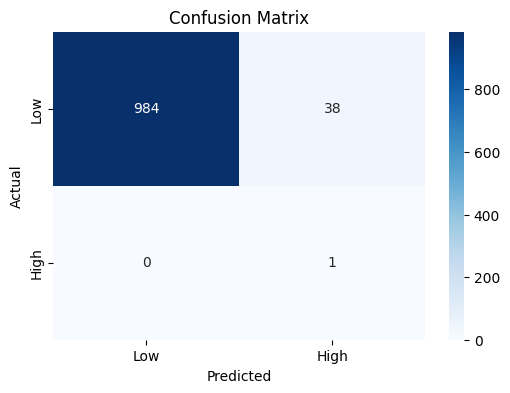

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.96      0.98      1022
        High       0.03      1.00      0.05         1

    accuracy                           0.96      1023
   macro avg       0.51      0.98      0.52      1023
weighted avg       1.00      0.96      0.98      1023



In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()


with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()


y_true = y_test_tensor.cpu().numpy()
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Low','High'], yticklabels=['Low','High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Low','High']))



## **Simulations**

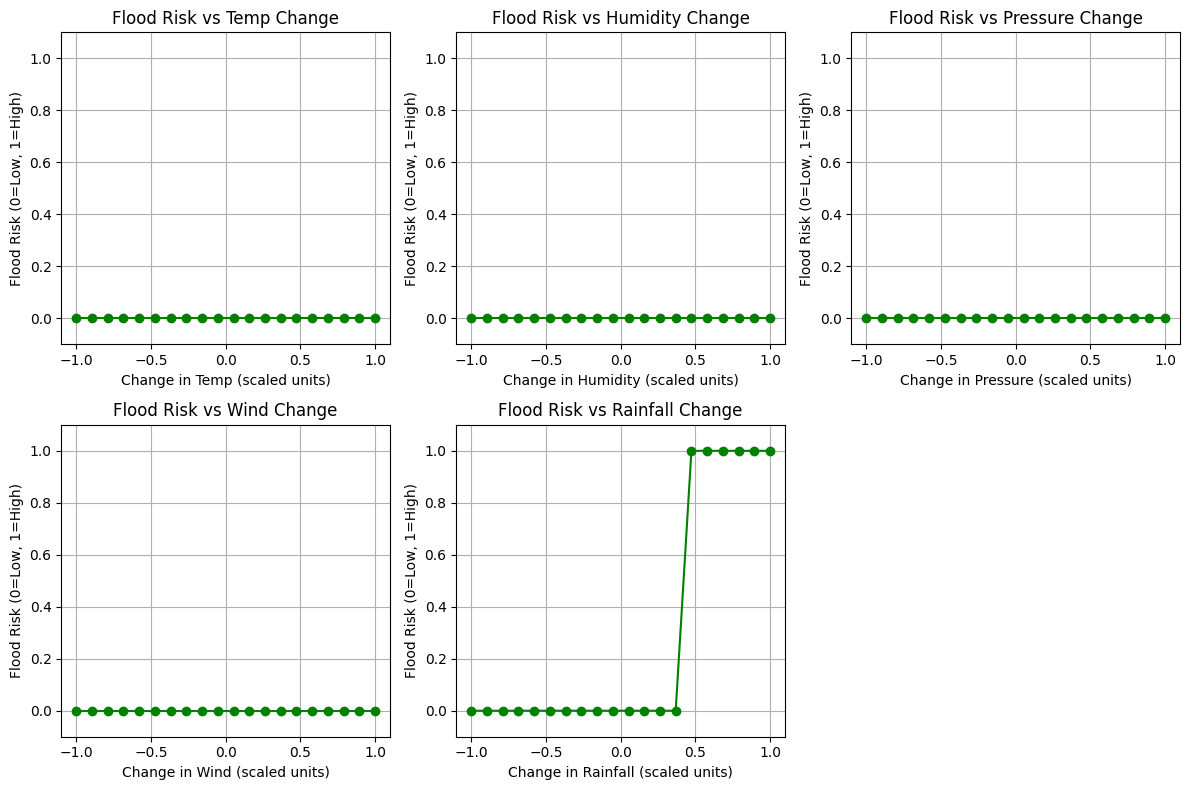

In [41]:
features = ['Temp', 'Humidity', 'Pressure', 'Wind', 'Rainfall']
changes = np.linspace(-1, 1, 20)

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    risks = []
    for change in changes:
        risk = simulate_weather_change(model, last_30_df, feature, change)
        risks.append(1 if risk == "High" else 0)

    plt.subplot(2, 3, i)
    plt.plot(changes, risks, marker='o', color="green")
    plt.title(f"Flood Risk vs {feature} Change")
    plt.xlabel(f"Change in {feature} (scaled units)")
    plt.ylabel("Flood Risk (0=Low, 1=High)")
    plt.ylim(-0.1, 1.1)
    plt.grid(True)

plt.tight_layout()
plt.show()





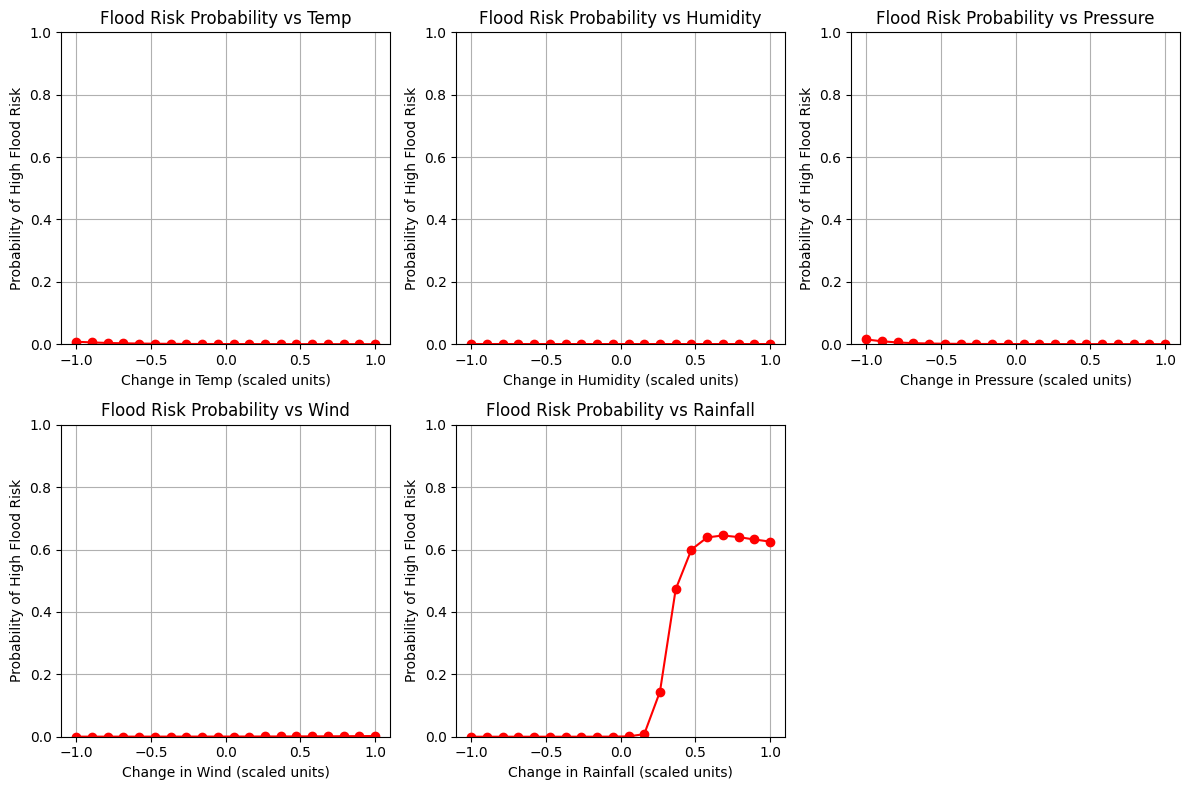

In [43]:
import torch.nn.functional as F

def simulate_prob_change(model, last_30_df, feature, change):

    data = last_30_df.copy()
    data[feature] = data[feature] + change


    data_tensor = torch.tensor(data.values[np.newaxis, :, :], dtype=torch.float32)


    with torch.no_grad():
        output = model(data_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
        return probs[1]


features = ['Temp', 'Humidity', 'Pressure', 'Wind', 'Rainfall']
changes = np.linspace(-1, 1, 20)

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    high_probs = []
    for change in changes:
        prob = simulate_prob_change(model, last_30_df, feature, change)
        high_probs.append(prob)

    plt.subplot(2, 3, i)
    plt.plot(changes, high_probs, marker='o', color="red")
    plt.title(f"Flood Risk Probability vs {feature}")
    plt.xlabel(f"Change in {feature} (scaled units)")
    plt.ylabel("Probability of High Flood Risk")
    plt.ylim(0, 1)
    plt.grid(True)

plt.tight_layout()
plt.show()


# **Dashboard**

In [47]:
from ipywidgets import interact, FloatSlider, VBox, HBox, Output
last_30_df = scaled_df[['Temp','Humidity','Pressure','Wind','Rainfall']].tail(30)

def predict_prob(model, seq_df):
    data_tensor = torch.tensor(seq_df.values[np.newaxis, :, :], dtype=torch.float32)
    with torch.no_grad():
        output = model(data_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
        return probs[1]

def simulate_prob_change(model, seq_df, feature, change):
    df = seq_df.copy()
    df[feature] = df[feature] + change
    data_tensor = torch.tensor(df.values[np.newaxis, :, :], dtype=torch.float32)
    with torch.no_grad():
        output = model(data_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
        return probs[1]

out = Output()

def update_dashboard(temp, humidity, pressure, wind, rainfall):

    new_seq = last_30_df.copy()
    new_seq.iloc[-1] = [temp, humidity, pressure, wind, rainfall]


    risk_prob = predict_prob(model, new_seq)

    with out:
        out.clear_output()
        print(f"Predicted Flood Risk Probability: {risk_prob*100:.1f}% chance of High Flood Risk")


        features = ['Temp','Humidity','Pressure','Wind','Rainfall']
        changes = np.linspace(-1, 1, 20)
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        for i, feature in enumerate(features):
            probs = [simulate_prob_change(model, last_30_df, feature, c) for c in changes]
            ax = axes[i//3, i%3]
            ax.plot(changes, probs, marker='*', color='blue')
            ax.set_title(f"{feature}")
            ax.set_xlabel("Change (scaled units)")
            ax.set_ylabel("High Flood Risk Prob")
            ax.set_ylim(0, 1)
            ax.grid(True)

        if len(features) < 6:
            axes[1,2].axis('off')

        plt.tight_layout()
        plt.show()

sliders = [FloatSlider(min=float(last_30_df[f].min()), max=float(last_30_df[f].max()),
                       step=0.01, value=float(last_30_df[f].iloc[-1]), description=f)
           for f in ['Temp','Humidity','Pressure','Wind','Rainfall']]

interact(update_dashboard, temp=sliders[0], humidity=sliders[1], pressure=sliders[2],
         wind=sliders[3], rainfall=sliders[4])

VBox([out])


interactive(children=(FloatSlider(value=0.062133645955451344, description='Temp', max=0.3610785463071513, min=…

# **Relevance to SDG 13**
## Relevance to SDG 13: Climate Action
This project contributes to climate resilience by predicting urban flooding risk in Karachi.  
Early warning systems like this can support adaptation strategies and reduce disaster impacts.
